In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import cv2
import os
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
%matplotlib inline

In [2]:
from tensorflow import keras

In [3]:
from keras.applications import VGG16

In [4]:
train = pd.read_csv('/Users/skylark/Desktop/dataset/train.csv')
test = pd.read_csv('/Users/skylark/Desktop/dataset/test.csv')

In [11]:
train['img'] = pd.to_numeric(train.Image.apply(lambda x: x.split('.')[0]))

In [22]:
test_new = test.copy()

In [23]:
test_new['img'] = pd.to_numeric(test.Image.apply(lambda x: x.split('.')[0]))

In [30]:
from keras.preprocessing import image

In [32]:
path_dir_train = '/Users/skylark/Desktop/dataset/train'
path_dir_test = '/Users/skylark/Desktop/dataset/test'

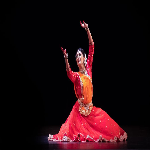

In [34]:
image.load_img(os.path.join(path_dir_train,train.Image[0]), target_size=(150, 150))

In [53]:
train_img = []
for i in train.Image:
    train_img.append(image.img_to_array(image.load_img(os.path.join(path_dir_train,i), target_size=(150, 150))))
train_img = np.array(train_img)    

In [56]:
test_img = []
for i in test.Image:
    test_img.append(image.img_to_array(image.load_img(os.path.join(path_dir_test,i), target_size=(150, 150))))
test_img = np.array(test_img)    

In [60]:
dance_dict = {}
for i,j in enumerate(train.target.unique()):
    dance_dict[j] = i

In [61]:
dance_dict

{'kathak': 0,
 'manipuri': 1,
 'bharatanatyam': 2,
 'kathakali': 3,
 'mohiniyattam': 4,
 'sattriya': 5,
 'kuchipudi': 6,
 'odissi': 7}

In [62]:
train['label'] = train.target.apply(lambda x: dance_dict[x])

In [64]:
from sklearn.model_selection import train_test_split

In [74]:
int(len(train_img)*0.3)

109

In [76]:
109*2

218

In [188]:
train_x, test_x, train_y, test_y = train_test_split(train_img/255, train.label, test_size=0.3, random_state=49)

In [175]:
datagen = image.ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

In [176]:
train_gen = datagen.flow(train_x[109:], train_y[109:])
test_gen = datagen.flow(test_x, test_y)
validation_gen = datagen.flow(train_x[:109], train_y[:109])

In [83]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

58892288/58889256 [==============================] - 29s 0us/step


In [84]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### Fast feature extraction without data augmentation

In [106]:
train_features = conv_base.predict(train_x[109:])
train_labels = train_y[109:]

In [107]:
validation_features = conv_base.predict(train_x[:109])
validation_labels = train_y[:109]

In [108]:
test_features = conv_base.predict(test_x)
test_labels = test_y

In [114]:
train_features = train_features.reshape(145, 4*4*512)
validation_features = validation_features.reshape(109, 4*4*512)
test_features = test_features.reshape(110, 4*4*512)

In [117]:
from keras import models, layers, optimizers, regularizers

In [147]:
model = models.Sequential()

In [148]:
model.add(layers.Dense(256, activation='relu', input_dim = 4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))

In [149]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [150]:
history = model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))

Train on 145 samples, validate on 109 samples
Epoch 1/30
145/145 [==============================] - 1s 3ms/step - loss: 2.2508 - acc: 0.0966 - val_loss: 2.0683 - val_acc: 0.0826
Epoch 2/30
145/145 [==============================] - 0s 1ms/step - loss: 2.1002 - acc: 0.1172 - val_loss: 2.0477 - val_acc: 0.1284
Epoch 3/30
145/145 [==============================] - 0s 2ms/step - loss: 2.0789 - acc: 0.1862 - val_loss: 2.0337 - val_acc: 0.1651
Epoch 4/30
145/145 [==============================] - 0s 2ms/step - loss: 2.0441 - acc: 0.1448 - val_loss: 2.0254 - val_acc: 0.1835
Epoch 5/30
145/145 [==============================] - 0s 2ms/step - loss: 2.0021 - acc: 0.2207 - val_loss: 2.0124 - val_acc: 0.2385
Epoch 6/30
145/145 [==============================] - 0s 2ms/step - loss: 2.0112 - acc: 0.2207 - val_loss: 1.9964 - val_acc: 0.2477
Epoch 7/30
145/145 [==============================] - 0s 2ms/step - loss: 1.9449 - acc: 0.2552 - val_loss: 1.9815 - val_acc: 0.2661
Epoch 8/30
145/145 [==========

In [151]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']

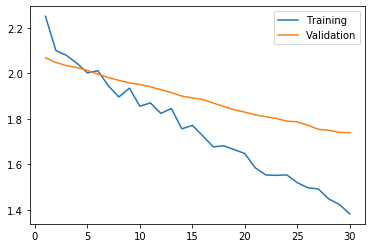

In [152]:
plt.plot(range(1, len(acc)+1), loss, label='Training')
plt.plot(range(1, len(acc)+1), val_loss, label='Validation')
plt.legend()
plt.show()

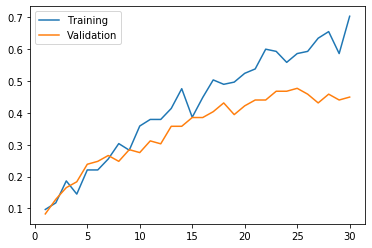

In [153]:
plt.plot(range(1, len(acc)+1), acc, label='Training')
plt.plot(range(1, len(acc)+1), val_acc, label='Validation')
plt.legend()
plt.show()

In [154]:
model.evaluate(test_features, test_labels)

110/110 [==============================] - 0s 418us/step


[1.7612015745856546, 0.4727272689342499]

### Feature extraction with image augmentation

In [187]:
model2 = models.Sequential()

In [189]:
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(8, activation='softmax'))

In [190]:
model2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_29 (Dense)             (None, 8)                 2056      
Total params: 16,814,152
Trainable params: 9,178,888
Non-trainable params: 7,635,264
_________________________________________________________________


In [180]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable=True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [191]:
model2.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [192]:
history = model2.fit_generator(train_gen, epochs=30, steps_per_epoch=100, validation_data=validation_gen, validation_steps=50)

Epoch 1/30
100/100 [==============================] - 761s 8s/step - loss: 0.8361 - acc: 0.7262 - val_loss: 1.3777 - val_acc: 0.4672
Epoch 2/30
100/100 [==============================] - 729s 7s/step - loss: 0.1745 - acc: 0.9521 - val_loss: 2.1030 - val_acc: 0.4789
Epoch 3/30
100/100 [==============================] - 788s 8s/step - loss: 0.0808 - acc: 0.9731 - val_loss: 2.0794 - val_acc: 0.4694
Epoch 4/30
100/100 [==============================] - 616s 6s/step - loss: 0.0401 - acc: 0.9893 - val_loss: 3.9298 - val_acc: 0.5203
Epoch 5/30
100/100 [==============================] - 617s 6s/step - loss: 0.0301 - acc: 0.9928 - val_loss: 2.0981 - val_acc: 0.5386
Epoch 6/30
100/100 [==============================] - 620s 6s/step - loss: 0.0233 - acc: 0.9931 - val_loss: 2.5010 - val_acc: 0.5255
Epoch 7/30
100/100 [==============================] - 670s 7s/step - loss: 0.0260 - acc: 0.9931 - val_loss: 2.4875 - val_acc: 0.5488
Epoch 8/30
100/100 [==============================] - 707s 7s/step - 

In [193]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [195]:
loss = history.history['loss']
acc = history.history['acc']

val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

In [196]:
range(1, len(loss)+1)

range(1, 31)

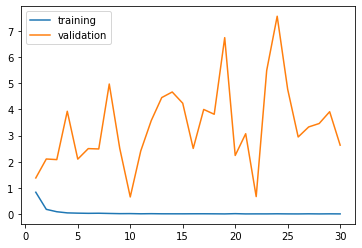

In [197]:
plt.plot(range(1,31), loss, label='training')
plt.plot(range(1,31), val_loss, label='validation')
plt.legend()
plt.show()

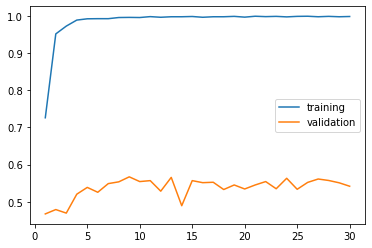

In [198]:
plt.plot(range(1,31), acc, label='training')
plt.plot(range(1,31), val_acc, label='validation')
plt.legend()
plt.show()

In [199]:
model.evaluate_generator(test_x)

[2.7157437801361084, 0.5727272629737854]

In [205]:
test_new['label'] = pred

In [229]:
test_new['target'] = test_new.label.apply(lambda x: dance_dict_rev[x])

In [233]:
test_new.sort_index(inplace=True)

In [241]:
test_new.set_index('Image').drop('label', axis=1).to_csv('/Users/skylark/Desktop/dataset/result.csv')